In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
from models import *
from utils import *
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Add, Conv2DTranspose, Input, Lambda, Reshape, LeakyReLU, Flatten, ReLU, Multiply, Subtract, Conv3D
from tensorflow.keras.models import *
import glob
import random
#import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import ops
import time
import pandas as pd
import matplotlib.pyplot as plt

2023-09-14 12:38:38.164476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 12:38:38.848599: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-14 12:38:38.848678: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-14 12:38:38.848686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

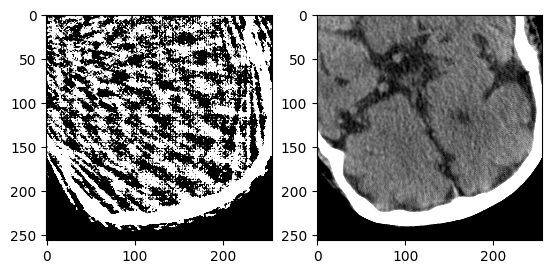

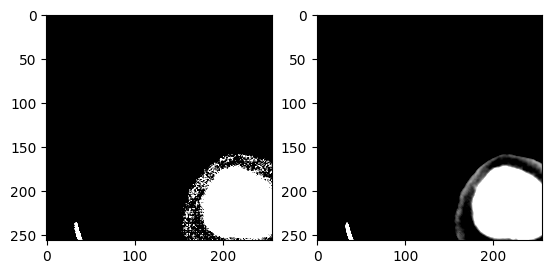

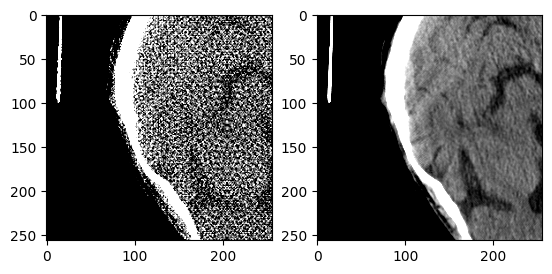

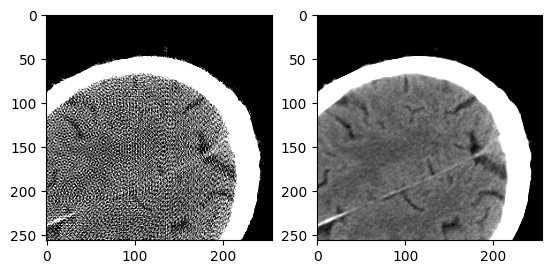

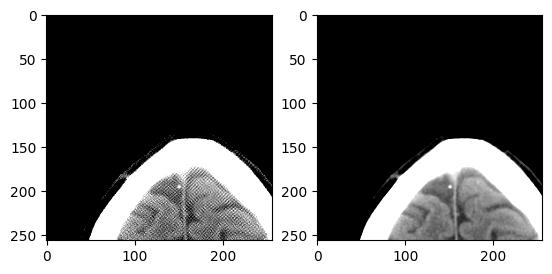

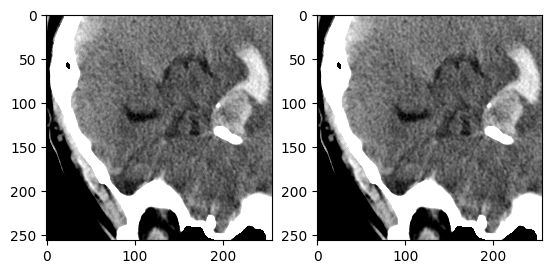

In [14]:
#check if data is loaded correctly 
for angle in [64, 128, 256, 512, 1024, 2048]:
    source_dir = "./Data/"
    train_list = pd.read_csv(os.path.abspath("./train_UNet.csv"))['filename'].tolist()
    val_list = pd.read_csv(os.path.abspath("./val_UNet.csv"))['filename'].tolist()
    data_gen = load_batch(train_list, source_dir, batchsize=4, angle=angle, shape=(256, 256))
    out = next(data_gen)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(out[0][0, :, :, 0]*4095 - 1024, cmap='gray', vmin=0, vmax=80)
    ax2.imshow(out[1][0, :, :, 0]*4095 - 1024, cmap='gray', vmin=0, vmax=80)

del data_gen, data_gen_val

In [ ]:
#train U-Net for each subsampled dataset
for angle in [64, 128, 256, 512, 1024, 2048]:

    save_path = os.path.abspath("./model_weights/U-Net/") + f"/{angle}/"
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
        print("\ncreated folder: ", save_path)

    #Instantiate optimzers:
    lr=1e-4
    beta_1 = 0.9
    beta_2 = 0.999

    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)

    #load model
    model = U_Net()
    model.compile(optimizer=optimizer, loss=loss_UNet)
    
    #initiate data generator
    source_dir = os.path.abspath(f"./Data/")
    train_list = pd.read_csv(os.path.abspath("./train_UNet.csv"))['filename'].tolist()
    val_list = pd.read_csv(os.path.abspath("./val_UNet.csv"))['filename'].tolist()

    batchsize = 32
    
    data_gen = load_batch(train_list, source_dir, batchsize=batchsize, angle=angle, shape=(256, 256))
    data_gen_val = load_batch(val_list, source_dir, batchsize=batchsize, angle=angle, shape=(256, 256))
    
    #define callbacks
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=save_path + '/model_{epoch:02d}.h5', verbose=1, period=5, save_weights_only=True), 
                tf.keras.callbacks.CSVLogger(save_path + '/log.csv', append=True, separator=','), 
                tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)]
    #start training
    model.fit(data_gen, epochs=75, steps_per_epoch=len(train_list)//batchsize, 
            validation_data = data_gen_val, validation_steps=len(val_list)//batchsize,
            callbacks=callbacks)
    

'ID_348f52e52.dcm'